## Libraries

In [3]:
import tempfile
import os
from subprocess import call
import matplotlib.pyplot as plt
from f90nml import *
from array import *
import numpy as np
import pandas as pd 
import seaborn as sns
from statistics import *
import shutil
import sys
from matplotlib.ticker import FormatStrFormatter

#read in printFolder, makeDefNameList, newFolder, deleteFolder, readOutput from coreFunctions.py
from coreFunctions import *

#read in plotting functionality from plottingFunctions.py
from plottingFunctions import *

call("rm -rf tmp*",shell=True)

dfModel = []#will contain output from our model

## Enter Custom Inputs, then Run the Model

In [14]:
nameList = makeDefNamelist() #make namelist
nameList['ebm']['lverbose']=True #controls terminal output, used for debugging
nameList['ebm']['N0']=1041
#earth-like, dt=190 years
nameList['ebm']['rco2']=1.9e-4
nameList['ebm']['rDeath']=0.0142857
nameList['ebm']['rBirth']=0.03001
nameList['ebm']['coupled'] = True

#equilibriumTs=[]
#pco2=[]

nameList['ebm']['runTime'] = 1000

#change distance
newA = 1#AU
nameList['ebm']['relsolcon']=newA**-2 #inverse square law for solar flux
#change pco2
newPco2=284#orginal is 284
nameList['ebm']['pco20']=newPco2/10**6

#make temporary directory to run in
with tempfile.TemporaryDirectory() as dirpath:
    runFolder = newFolder(nameList,dirpath) #make the temporary folder

    runProgram("driver.exe") #windows intel compiler outputs driver.exe  (vs linux outputs driver)

    dfModel, finalavgtemp, eqTime, eqTemp = readOutput() #read output into datframe

    os.chdir(notePath) 
    call("rm -rf tmp*", shell=True)#delete the temporary folder and unlink it's contents
    print('Equilibrium Reached at Temp=' + str(eqTemp)+". At time="+str(eqTime))
    print('Final Temp(K): ' + str(finalavgtemp));
    #print('Final Temp(F): ' + str(round((finalavgtemp-273.15)*(9/5)+32,2)));
    print('')
    call("echo   ", shell=True)
    call("echo End of Python Notebook Reached",shell=True)

#pco2.append(i)
#equilibriumTs.append(eqTemp)

Equilibrium Reached at Temp=287.09. At time=22.0
Final Temp(K): 296.43



### Visualize Our Model's Inputs/Outputs

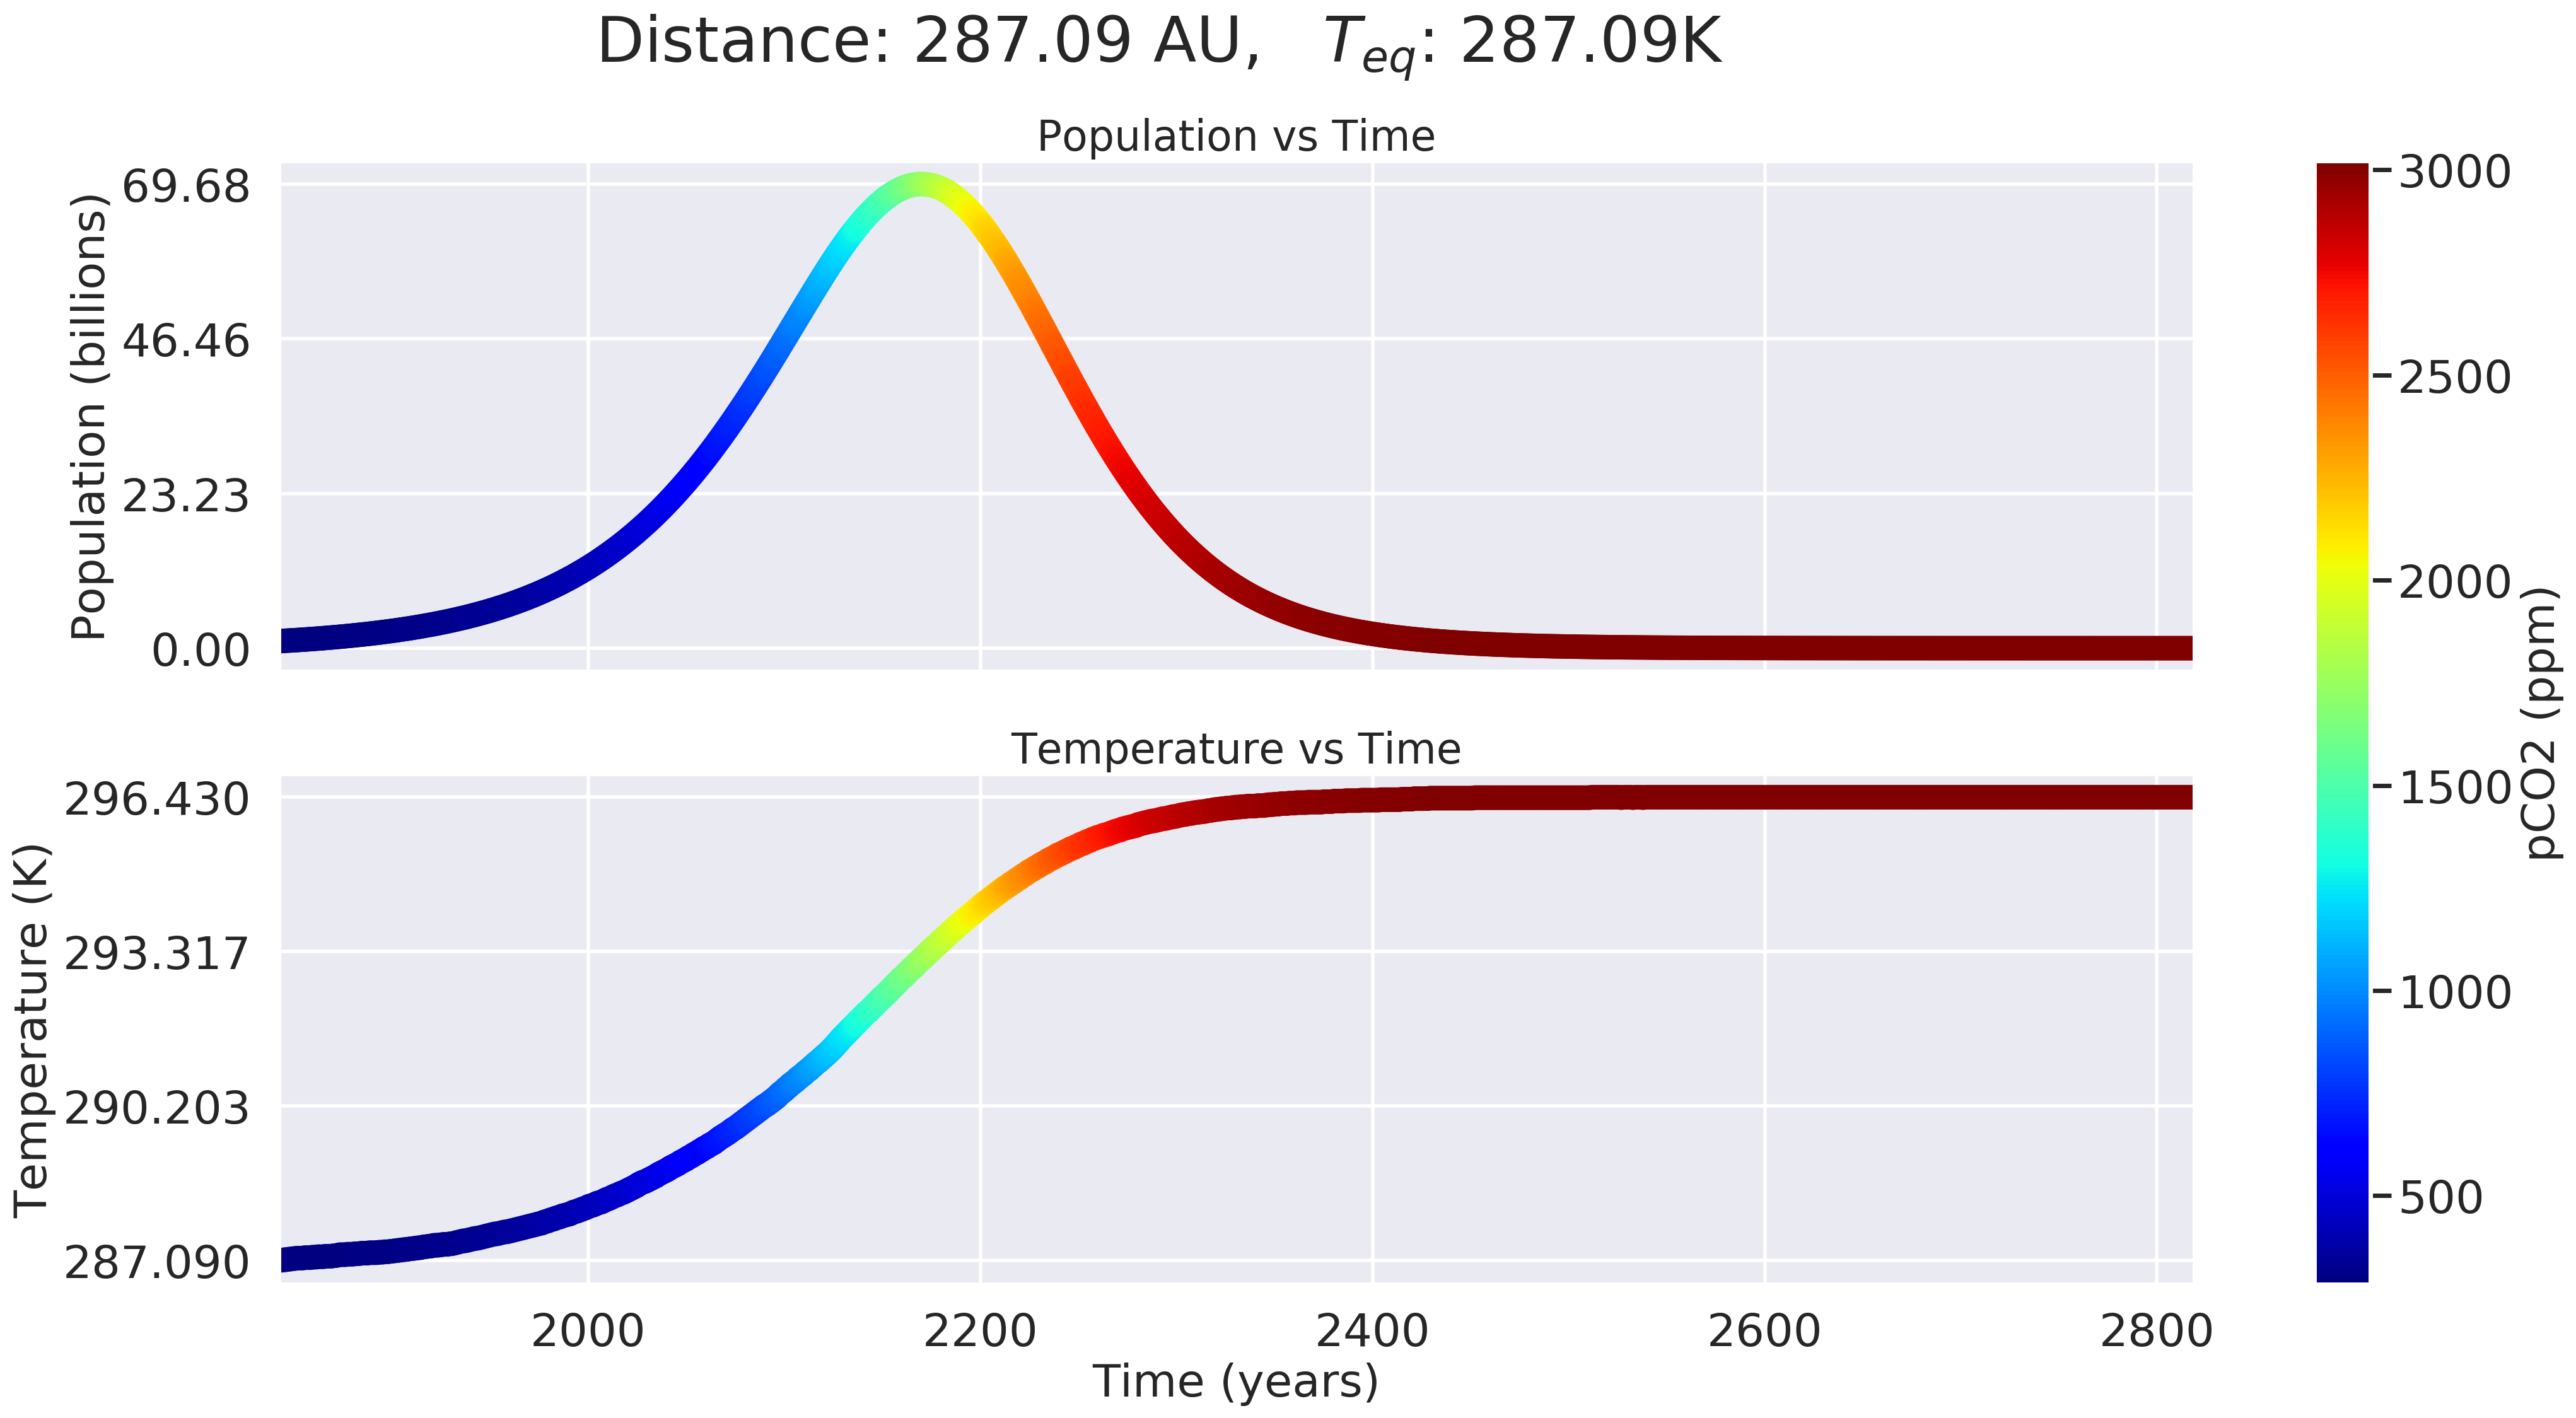

In [15]:
#plotModelInput(nameList)#plot the temperature dependence on the growth rate
plotModelOutput(dfModel,eqTemp,eqTime,eqTemp)#plot the output of our model, colored by pco2 

## Compare Our Output to True Values

In [ ]:
dfTemp = pd.read_csv('anomaly.csv');#data from NASA GISS: https://data.giss.nasa.gov/gistemp/graphs_v4/
dfPopCo2 = pd.read_csv('world_stats.csv');#data from Frank, Adam, and Woodruff Sullivan.

#plotTruePopCo2(dfPopCo2) #plot true population values vs pco2
#compareModelOutput(dfModel,dfTemp,dfPopCo2)#compare the models output to true data